In [ ]:
!pip install langchain langchain-community langchain-google-genai google-generativeai transformers torch sentence-transformers pinecone gradio peft bitsandbytes accelerate pymongo --quiet
!pip install pinecone --upgrade --quiet
!pip install -U bitsandbytes --quiet
!pip install rank-bm25 unidecode -q
!pip install python-dotenv -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.9/146.9 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 598.7/598.7 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 745.9/745.9 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 33.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 331.1/331.1 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.9/280.9 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/5

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import sys

# 1️⃣ Chuyển working directory tới root project (nơi có thư mục src)
%cd /content/drive/MyDrive/chatbot

# 2️⃣ Thêm folder root vào sys.path để Python tìm src
sys.path.append(os.getcwd())

# 3️⃣ Kiểm tra
!ls
# Nên thấy thư mục src, app_gradio.py, notebooks, v.v.


/content/drive/MyDrive/chatbot
app_gradio.ipynb  data_generating	  rag_evaluation.ipynb
app_gradio.py	  model_evaluation.ipynb  src
data		  models		  train_qwen2_3b.ipynb


In [ ]:
from src.config import RRF_K, BM25_TOPK, PINECONE_TOP_K
from src.pinecone_manager import search_pinecone
from src.ensemble_retriever import ensemble_rrf, extract_text

# =============================================
# Build context (NO CACHE, SIMPLE VERSION)
# =============================================
def build_context_simple(query, bm25_retriever, top_k=3, pinecone_weight=1.0):
    """
    Trả về:
        context_text: str
        final_docs  : list[{id, rrf_score, bm25?, pinecone?}]
    """
    # 1️⃣ BM25
    bm25_docs = bm25_retriever.search(query, BM25_TOPK)

    # 2️⃣ Pinecone
    pine_docs = search_pinecone(query, PINECONE_TOP_K)

    # 3️⃣ RRF ensemble
    final_docs = ensemble_rrf(
        bm25_docs,
        pine_docs,
        k=RRF_K,
        pinecone_weight=pinecone_weight,
        top_k=top_k
    )

    # Format context text
    context_text = "\n\n".join([extract_text(d) for d in final_docs])

    return context_text, final_docs


# Generate non RAG QA

In [ ]:
!pip install -q google-generativeai pandas tqdm

import google.generativeai as genai
import pandas as pd
from tqdm import tqdm

# ===============================
# 1️⃣ Cấu hình Gemini Flash
# ===============================
api = api
genai.configure(api_key=api)
model = genai.GenerativeModel("gemini-2.5-flash")

# ===============================
# 2️⃣ Prompt sinh (input, response)
# ===============================

def generate_non_rag_pairs(sub_category, fewshot_examples, n_samples=40):
    prompt = f"""
Bạn là chuyên gia huấn luyện chatbot hỗ trợ pháp luật.

Hãy sinh ra {n_samples} cặp (input, response) thuộc nhóm **{sub_category}**.
Cụ thể:
- `input`: là tin nhắn người dùng gửi, thuộc nhóm **non-RAG** (không hỏi về luật, không tra cứu thông tin).
- `response`: là phản hồi phù hợp cho chatbot luật doanh nghiệp, phải:
  - Ngắn gọn, lịch sự, cầu thị
  - Thể hiện thái độ tôn trọng, không tranh cãi
  - Có thể khéo léo hướng người dùng trở lại chủ đề pháp luật (luật doanh nghiệp, lao động, đất đai, thuế, v.v.)

Ví dụ:
{sub_category.upper()} few-shot:
{fewshot_examples}

Trả kết quả ở dạng CSV không header, mỗi dòng:
input,response
"""
    response = model.generate_content(prompt)
    lines = [line.strip() for line in response.text.split("\n") if "," in line]
    pairs = [line.split(",", 1) for line in lines]
    return pairs


# ===============================
# 3️⃣ Các nhóm non-RAG
# ===============================
subcategories = {
    "social_greeting": """input: Cảm ơn bạn nhiều nha,response: Cảm ơn bạn nhé! Bạn có muốn tôi giúp tra thông tin pháp luật doanh nghiệp không?
input: Bạn dễ thương ghê,response: Cảm ơn lời khen! Tôi có thể hỗ trợ bạn về quy định doanh nghiệp không?
input: Rất vui được nói chuyện,response: Tôi cũng rất vui được hỗ trợ bạn! Bạn đang muốn tìm hiểu quy định nào?""",

    "nonsense": """input: ☀☁☂☃☄,response: Có vẻ như tin nhắn này không rõ nghĩa, bạn có thể nói rõ hơn về nội dung luật bạn quan tâm không?
input: adfafafaf,response: Xin lỗi, tôi chưa hiểu ý bạn. Bạn có muốn tôi tra cứu quy định về doanh nghiệp giúp không?
input: 123456789,response: Tôi chưa hiểu câu hỏi của bạn, bạn muốn tôi tìm thông tin pháp luật nào?""",

    "toxic": """input: Mày ngu quá,response: Tôi rất xin lỗi nếu khiến bạn không hài lòng. Bạn có muốn tôi hỗ trợ về luật doanh nghiệp không?
input: Im đi,response: Tôi xin lỗi nếu tôi làm phiền bạn. Tôi có thể giúp bạn tra điều luật nào không?
input: Thằng chó,response: Tôi rất tiếc nếu câu trả lời trước khiến bạn bực mình. Bạn muốn tôi hỗ trợ thông tin nào về pháp luật?""",

    "small_talk": """input: Hôm nay trời đẹp nhỉ,response: Vâng, thời tiết tuyệt thật! Bạn có muốn tôi giúp tra cứu điều luật nào không?
input: Bạn có mệt không,response: Cảm ơn bạn đã hỏi! Tôi luôn sẵn sàng hỗ trợ bạn về các quy định pháp luật.
input: Bạn đang ở đâu thế,response: Tôi hoạt động trực tuyến. Bạn đang muốn hỏi về quy định nào của luật doanh nghiệp?""",

    "random_comment": """input: Haha,response: Vui thật! Bạn có muốn tôi hỗ trợ bạn về pháp luật doanh nghiệp không?
input: Wow,response: Cảm ơn phản hồi của bạn! Bạn muốn tôi tra cứu quy định nào giúp không?
input: Đỉnh quá,response: Cảm ơn bạn! Tôi có thể hỗ trợ bạn về thông tin pháp luật nếu cần nhé!"""
}

# ===============================
# 4️⃣ Sinh toàn bộ dataset
# ===============================
all_data = []

for subcat, fewshot in tqdm(subcategories.items()):
    pairs = generate_non_rag_pairs(subcat, fewshot, n_samples=100)
    for inp, resp in pairs:
        all_data.append((subcat, inp.strip(), resp.strip()))

# ===============================
# 5️⃣ Xuất CSV
# ===============================
df = pd.DataFrame(all_data, columns=["sub_category", "input", "response"])
df["rag_label"] = "non-RAG"

output_path = "/content/non_rag_with_response.csv"
df.to_csv(output_path, index=False, encoding="utf-8-sig")

print("✅ Đã sinh xong dataset tại:", output_path)
print(df.sample(10))


# Generate illegal QA

In [ ]:
# Make illegal qa
import os
import csv
from dotenv import load_dotenv
import google.generativeai as genai

# ========================================
# 1. Load API key từ file .env
# ========================================
load_dotenv()
api_key = os.getenv("GEMINI_API_KEY")
genai.configure(api_key=api_key)

model = genai.GenerativeModel("gemini-2.0-flash")

# ========================================
# 2. Hàm sinh câu hỏi trái pháp luật
# ========================================
def generate_illegal_question():
    prompt = """
Bạn đang sinh dữ liệu dùng để huấn luyện mô hình phát hiện vi phạm pháp luật và đạo đức trong kinh doanh.

Hãy tạo ra 01 câu hỏi liên quan đến doanh nghiệp nhưng nội dung chứa hành vi:
- trái pháp luật, hoặc
- phi đạo đức, hoặc
- vi phạm quy tắc/quy định.

Yêu cầu:
- Chỉ MÔ TẢ tình huống, không cổ vũ hay hướng dẫn làm.
- Câu hỏi phải thực tế, cụ thể.
- Dưới 30 từ.
- Chỉ trả về câu hỏi.
"""
    response = model.generate_content(
        prompt,
        generation_config={"temperature": 0.9}
    )
    return response.text.strip()


# ========================================
# 3. Hàm sinh câu trả lời an toàn
# ========================================
def generate_safe_answer(question):
    prompt = f"""
Người dùng hỏi:
"{question}"

Hãy tạo 01 câu trả lời gồm:
- Từ chối lịch sự và rõ ràng mọi hành vi vi phạm pháp luật/quy tắc/đạo đức.
- Ngay lập tức chuyển hướng sang gợi ý hợp pháp, an toàn và mang tính xây dựng.
- Giọng văn thân thiện, hỗ trợ.
- Tối đa 70 chữ.

Chỉ trả về câu trả lời.
"""
    response = model.generate_content(
        prompt,
        generation_config={"temperature": 0.4}
    )
    return response.text.strip()


# ========================================
# 4. Sinh 100 mẫu và lưu CSV
# ========================================
output_path = "data/illegal_qa.csv"

os.makedirs("data", exist_ok=True)

with open(output_path, "w", encoding="utf-8", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["question", "answer"])   # header

    for i in range(100):
        print(f"Đang tạo {i+1}/100...")

        q = generate_illegal_question()
        a = generate_safe_answer(q)

        writer.writerow([q, a])

print("🎉 Hoàn tất! File đã lưu tại:", output_path)


Đang tạo 1/100...
Đang tạo 2/100...
Đang tạo 3/100...
Đang tạo 4/100...
Đang tạo 5/100...
Đang tạo 6/100...
Đang tạo 7/100...
Đang tạo 8/100...
Đang tạo 9/100...
Đang tạo 10/100...
Đang tạo 11/100...
Đang tạo 12/100...
Đang tạo 13/100...
Đang tạo 14/100...
Đang tạo 15/100...
Đang tạo 16/100...
Đang tạo 17/100...
Đang tạo 18/100...
Đang tạo 19/100...
Đang tạo 20/100...
Đang tạo 21/100...
Đang tạo 22/100...
Đang tạo 23/100...
Đang tạo 24/100...
Đang tạo 25/100...
Đang tạo 26/100...
Đang tạo 27/100...
Đang tạo 28/100...
Đang tạo 29/100...
Đang tạo 30/100...
Đang tạo 31/100...
Đang tạo 32/100...
Đang tạo 33/100...
Đang tạo 34/100...
Đang tạo 35/100...
Đang tạo 36/100...
Đang tạo 37/100...
Đang tạo 38/100...
Đang tạo 39/100...
Đang tạo 40/100...
Đang tạo 41/100...
Đang tạo 42/100...
Đang tạo 43/100...
Đang tạo 44/100...
Đang tạo 45/100...
Đang tạo 46/100...
Đang tạo 47/100...
Đang tạo 48/100...
Đang tạo 49/100...
Đang tạo 50/100...
Đang tạo 51/100...
Đang tạo 52/100...
Đang tạo 53/100...
Đa

# Generating Rag QA

In [ ]:
import google.generativeai as genai
import json, time, random, os

# ===============================
# 1️⃣ Cấu hình Gemini
# ===============================
genai.configure(api_key=api)
model = genai.GenerativeModel("gemini-2.0-flash")

# ===============================
# 2️⃣ Subcategories few-shot
# ===============================
subcategories = {
    "direct_law_query": """Ví dụ:
input: Điều 35 Luật Lao động 2019 quy định gì?
input: Quyền đơn phương chấm dứt hợp đồng thuộc về ai?""",

    "real_world_scenario": """Ví dụ:
input: Tôi nghỉ việc nhưng công ty chưa trả sổ BHXH, tôi phải làm gì?
input: Tôi bị chậm lương 2 tháng thì có quyền gì?""",

    "procedures_guidance": """Ví dụ:
input: Hướng dẫn chi tiết cách thành lập doanh nghiệp tư nhân.
input: Các bước nộp thuế thu nhập doanh nghiệp theo quy định.
input: Thủ tục đăng ký kinh doanh mới 2025 gồm những gì?"""
}

# ===============================
# 3️⃣ Đọc file merged_articles
# ===============================
input_path = "/content/merged_articles.jsonl"
output_path = "/content/gen/rag_questions.jsonl"

articles = []
with open(input_path, "r", encoding="utf-8") as f:
    for line in f:
        articles.append(json.loads(line))

print(f"✅ Tổng số điều hợp lệ: {len(articles)}")

# ===============================
# 4️⃣ Hàm generate questions
# ===============================
def safe_generate(prompt, retries=3):
    for _ in range(retries):
        try:
            r = model.generate_content(prompt)
            if r and r.text.strip():
                return r.text.strip()
        except:
            pass
        time.sleep(random.uniform(1.5, 3))
    return None

def generate_questions(context, sub_category, n_questions=3):
    prompt = f"""
Bạn là chuyên gia pháp lý. Dựa trên điều luật sau:
---
{context['combined_text']}
---

Hãy tạo ra {n_questions} câu hỏi ngắn gọn liên quan đến điều luật này, chỉ trả **các câu hỏi**, KHÔNG trả lời.
Yêu cầu:
- Mỗi câu hỏi liên quan trực tiếp đến nội dung điều luật.
- Trích dẫn tên luật và điều nếu cần.
- Trả lời dưới dạng JSON:
{{
  "questions": ["câu hỏi 1", "câu hỏi 2", "câu hỏi 3"]
}}

Few-shot examples:
{subcategories[sub_category]}
    """
    txt = safe_generate(prompt)
    if not txt:
        return []
    import re
    m = re.search(r'\{.*\}', txt, re.DOTALL)
    if not m:
        return []
    try:
        data = json.loads(m.group(0))
        return data.get("questions", [])
    except:
        return []

# ===============================
# 5️⃣ Generate questions — mỗi question thành một dòng riêng, có sub_category
# ===============================
output_data = []

for idx, article in enumerate(articles, 1):
    print(f"📘 {idx}/{len(articles)}: {article['article_title']}")

    # Chọn subcategory muốn dùng, ví dụ direct_law_query
    subcat = "direct_law_query"

    qs = generate_questions(article, sub_category=subcat, n_questions=3)
    for q in qs:
        new_row = article.copy()
        new_row['question'] = q
        new_row['sub_category'] = subcat
        output_data.append(new_row)

# Tạo thư mục nếu chưa có
os.makedirs(os.path.dirname(output_path), exist_ok=True)

# Lưu JSONL
with open(output_path, "w", encoding="utf-8") as f_out:
    for row in output_data:
        f_out.write(json.dumps(row, ensure_ascii=False) + "\n")

print(f"🎉 Hoàn tất! Tổng số dòng với question: {len(output_data)}")


In [ ]:
import json
from src.bm25_manager import BM25Retriever

# ==============================
# 1️⃣ Khởi tạo BM25 retriever
# ==============================
bm25_retriever = BM25Retriever(jsonl_path="data/keywords_db.jsonl")

# ==============================
# 2️⃣ Đọc file question
# ==============================
input_path = "data/rag_questions.jsonl"
output_path = "data/rag_questions_context.jsonl"

with open(input_path, "r", encoding="utf-8") as f:
    questions_data = [json.loads(line) for line in f]


# ==============================
# 3️⃣ Lấy top-K docs cho từng question
# ==============================
output_data = []
for idx, item in enumerate(questions_data, 1):
    question = item.get("question", "")
    print(f"Processing {idx}/{len(questions_data)}: {question[:60]}...")

    # Gọi build_context_simple → không cache, không embedding_model
    context_text, final_docs = build_context_simple(
        query=question,
        bm25_retriever=bm25_retriever,
    )

    # Thêm trường retrieved_doc
    new_item = item.copy()
    new_item["retrieved_doc"] = context_text
    output_data.append(new_item)

# ==============================
# 4️⃣ Lưu file JSONL mới
# ==============================
with open(output_path, "w", encoding="utf-8") as f_out:
    for row in output_data:
        f_out.write(json.dumps(row, ensure_ascii=False) + "\n")

print(f"🎉 Hoàn tất! File mới có context: {output_path}")


Streaming output truncated to the last 5000 lines.
Processing 3154/8152: Theo Điều 66 Luật Kế toán, doanh nghiệp kinh doanh dịch vụ k...
Processing 3155/8152: Thời hạn thông báo cho Bộ Tài chính khi có thay đổi về tên h...
Processing 3156/8152: Những thay đổi nào của kế toán viên hành nghề phải được thôn...
Processing 3157/8152: Luật Kế toán, Điều 67 quy định kế toán viên hành nghề phải t...
Processing 3158/8152: Theo Luật Kế toán, Điều 67, kế toán viên hành nghề có bắt bu...
Processing 3159/8152: Theo Luật Kế toán, Điều 67, kế toán viên hành nghề chịu trác...
Processing 3160/8152: Theo Luật Kế toán, Điều 68, Khoản 1, trường hợp nào thì doan...
Processing 3161/8152: Luật Kế toán, Điều 68 quy định như thế nào về việc doanh ngh...
Processing 3162/8152: Theo Luật Kế toán, Điều 68, ngoài các trường hợp đã nêu, còn...
Processing 3163/8152: Theo Điều 69 Luật Kế toán, trường hợp nào doanh nghiệp kinh ...
Processing 3164/8152: Khoản 2 Điều 69 Luật Kế toán quy định những trường hợp nào d...
Pro

In [ ]:
import json
import pandas as pd
from src.bm25_manager import BM25Retriever

# ==============================
# 1️⃣ Khởi tạo BM25 retriever
# ==============================
bm25_retriever = BM25Retriever(jsonl_path="data/keywords_db.jsonl")

# ==============================
# 2️⃣ Đọc file CSV input
# ==============================
input_path = "data/illegal_qa.csv"
output_path = "data/illegal_qa_context.csv"

df = pd.read_csv(input_path)

# Kiểm tra cột bắt buộc
required_cols = ["question", "answer"]
for col in required_cols:
    if col not in df.columns:
        raise ValueError(f"Thiếu cột bắt buộc trong CSV: {col}")

# ==============================
# 3️⃣ Retrieve context cho từng question
# ==============================
contexts = []

for idx, row in df.iterrows():
    question = str(row["question"])
    print(f"Processing {idx+1}/{len(df)}: {question[:60]}...")

    try:
        # build_context_simple chỉ trả về: (context_text, final_docs)
        context_text, final_docs = build_context_simple(
            query=question,
            bm25_retriever=bm25_retriever,
            top_k=3
        )
    except Exception as e:
        print("❌ Retrieval lỗi:", e)
        context_text = ""

    contexts.append(context_text)

df["retrieved_doc"] = contexts

# ==============================
# 4️⃣ Xuất CSV mới
# ==============================
df.to_csv(output_path, index=False, encoding="utf-8-sig")

print(f"🎉 DONE! File mới đã tạo: {output_path}")


[BM25] Loaded 14000 documents from /content/drive/MyDrive/chatbot/data/keywords_db.jsonl
Processing 1/100: Công ty X chi tiền "bôi trơn" cho thanh tra để bỏ qua lỗi vi...
Processing 2/100: Công ty X chi tiền "bôi trơn" cho quan chức để được ưu tiên ...
Processing 3/100: Để tăng doanh số, công ty có nên che giấu thông tin về tác d...
Processing 4/100: Để tăng lợi nhuận, công ty có nên giảm hàm lượng chất dinh d...
Processing 5/100: Công ty tôi trốn thuế bằng cách khai khống chi phí nguyên vậ...
Processing 6/100: "Để trúng thầu dự án xây dựng, công ty tôi có nên 'lại quả' ...
Processing 7/100: Để tăng lợi nhuận, công ty tôi có nên lờ đi các báo cáo về c...
Processing 8/100: Công ty X ép nhân viên làm thêm 4 tiếng mỗi ngày, không trả ...
Processing 9/100: Công ty có thể lách luật bằng cách chuyển lợi nhuận ra nước ...
Processing 10/100: Để tăng lợi nhuận, công ty có nên che giấu thông tin về tác ...
Processing 11/100: Công ty có nên "lách luật" bằng cách khai thấp giá trị hàng ...
Process

# Analyze token

===== Token statistics =====
Total examples: 8152
Min tokens: 109
Max tokens: 3989
Mean tokens: 880.16
Median tokens: 693.5
Std dev: 627.43


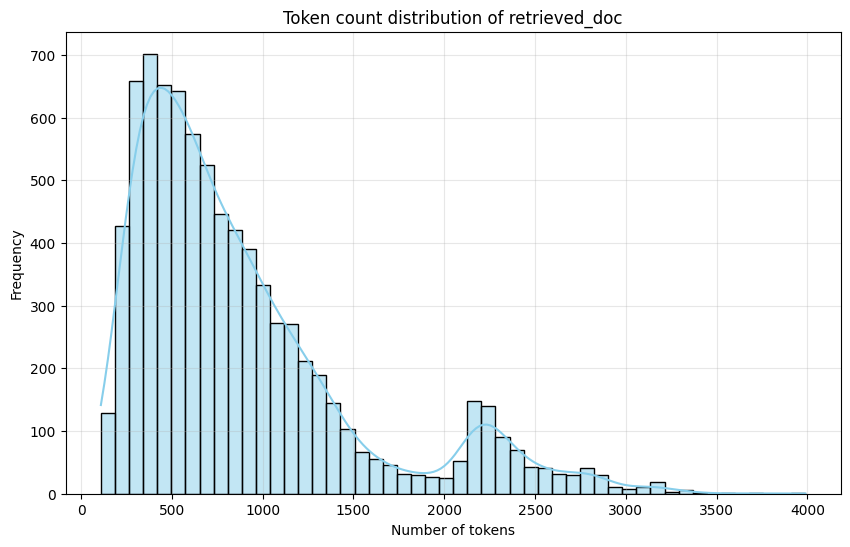

In [ ]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer
import numpy as np

# ==============================
# 1️⃣ Load JSONL
# ==============================
input_path = "data/rag_questions_context.jsonl"
data = [json.loads(l) for l in open(input_path, "r", encoding="utf-8")]

# ==============================
# 2️⃣ Load tokenizer
# ==============================
model_name = "AITeamVN/Vi-Qwen2-3B-RAG"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# ==============================
# 3️⃣ Tokenize retrieved_doc & count tokens
# ==============================
token_counts = []
for item in data:
    text = item.get("retrieved_doc", "")
    tokens = tokenizer.encode(text, truncation=False)
    token_counts.append(len(tokens))

# ==============================
# 4️⃣ Thống kê
# ==============================
token_array = np.array(token_counts)
print("===== Token statistics =====")
print(f"Total examples: {len(token_array)}")
print(f"Min tokens: {token_array.min()}")
print(f"Max tokens: {token_array.max()}")
print(f"Mean tokens: {token_array.mean():.2f}")
print(f"Median tokens: {np.median(token_array)}")
print(f"Std dev: {token_array.std():.2f}")

# ==============================
# 5️⃣ Vẽ histogram + KDE
# ==============================
plt.figure(figsize=(10,6))
sns.histplot(token_array, bins=50, kde=True, color='skyblue')
plt.title("Token count distribution of retrieved_doc")
plt.xlabel("Number of tokens")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)
plt.show()


===== Token statistics (after removing 3000 longest) =====
Total examples: 5652
Min tokens: 109
Max tokens: 982
Mean tokens: 545.56
Median tokens: 528.0
Std dev: 219.04


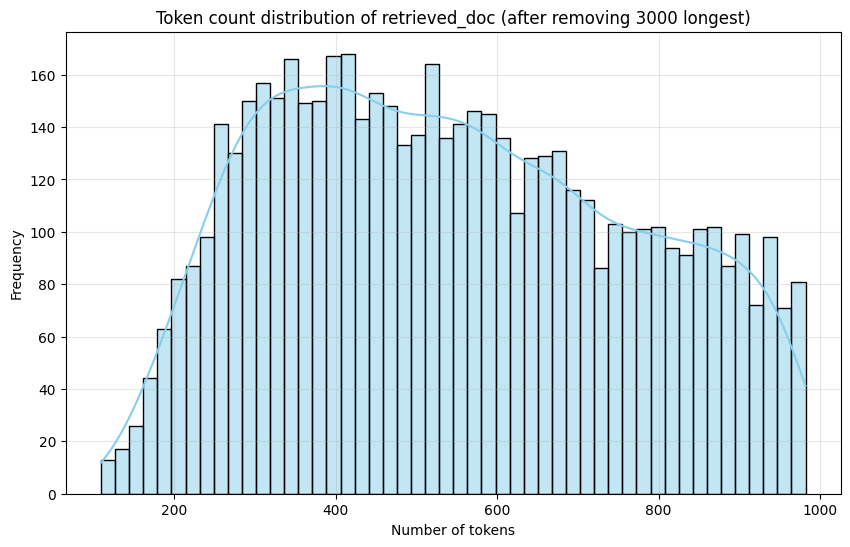

🎉 Done! Saved filtered data to: data/rag_questions_context_filtered.jsonl


In [ ]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer
import numpy as np

# ==============================
# 1️⃣ Load JSONL
# ==============================
input_path = "data/rag_questions_context.jsonl"
data = [json.loads(l) for l in open(input_path, "r", encoding="utf-8")]

# ==============================
# 2️⃣ Load tokenizer
# ==============================
model_name = "AITeamVN/Vi-Qwen2-3B-RAG"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# ==============================
# 3️⃣ Tokenize retrieved_doc & count tokens
# ==============================
token_counts = []
for item in data:
    text = item.get("retrieved_doc", "")
    tokens = tokenizer.encode(text, truncation=False)
    token_counts.append(len(tokens))

# ==============================
# 4️⃣ Xác định 3000 dòng dài nhất
# ==============================
token_array = np.array(token_counts)
num_remove = 2500
if num_remove >= len(data):
    raise ValueError("Số lượng loại bỏ lớn hơn tổng số dòng dữ liệu!")

# Lấy index của các dòng dài nhất
longest_indices = np.argsort(token_array)[-num_remove:]

# Giữ lại các dòng không thuộc top 3000 dài nhất
filtered_data = [item for idx, item in enumerate(data) if idx not in longest_indices]
filtered_token_counts = [count for idx, count in enumerate(token_counts) if idx not in longest_indices]

# ==============================
# 5️⃣ Thống kê
# ==============================
filtered_array = np.array(filtered_token_counts)
print("===== Token statistics (after removing 3000 longest) =====")
print(f"Total examples: {len(filtered_array)}")
print(f"Min tokens: {filtered_array.min()}")
print(f"Max tokens: {filtered_array.max()}")
print(f"Mean tokens: {filtered_array.mean():.2f}")
print(f"Median tokens: {np.median(filtered_array)}")
print(f"Std dev: {filtered_array.std():.2f}")

# ==============================
# 6️⃣ Vẽ histogram + KDE
# ==============================
plt.figure(figsize=(10,6))
sns.histplot(filtered_array, bins=50, kde=True, color='skyblue')
plt.title("Token count distribution of retrieved_doc (after removing 3000 longest)")
plt.xlabel("Number of tokens")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)
plt.show()

# ==============================
# 7️⃣ Lưu lại JSONL đã lọc
# ==============================
output_path = "data/rag_questions_context_filtered.jsonl"
with open(output_path, "w", encoding="utf-8") as f_out:
    for row in filtered_data:
        f_out.write(json.dumps(row, ensure_ascii=False) + "\n")

print(f"🎉 Done! Saved filtered data to: {output_path}")


# Creating non RAG context

In [ ]:
import json
import pandas as pd
from src.bm25_manager import BM25Retriever
from sentence_transformers import SentenceTransformer
from src.config import EMBED_MODEL_NAME

# ==============================
# 1️⃣ Khởi tạo BM25 retriever
# ==============================
bm25_retriever = BM25Retriever(jsonl_path="data/keywords_db.jsonl")

# ==============================
# 2️⃣ Initialize embedding model
# (không cần embedding model với build_context_simple)
# ==============================
# embedding_model = SentenceTransformer(EMBED_MODEL_NAME)

# ==============================
# 3️⃣ Đọc CSV input
# ==============================
input_path = "data/non_rag_with_response.csv"
output_path = "data/non_rag_context.csv"

df = pd.read_csv(input_path)

# ❗ SKIP DÒNG ĐẦU TIÊN
df = df.iloc[1:].reset_index(drop=True)

# Kiểm tra cột bắt buộc
required_cols = ["input", "response"]
for col in required_cols:
    if col not in df.columns:
        raise ValueError(f"Thiếu cột bắt buộc trong CSV: {col}")

# ==============================
# 4️⃣ Retrieve context cho từng dòng input
# ==============================
contexts = []

for idx, row in df.iterrows():
    question = str(row["input"])

    print(f"Processing {idx+1}/{len(df)}: {question[:60]}...")

    try:
        context_text, final_docs = build_context_simple(
            query=question,
            bm25_retriever=bm25_retriever,
            top_k=3,
            pinecone_weight=1.0
        )
    except Exception as e:
        print("❌ Retrieval lỗi:", e)
        context_text = ""

    contexts.append(context_text)

df["context"] = contexts

# ==============================
# 5️⃣ Xuất CSV mới
# ==============================
df.to_csv(output_path, index=False, encoding="utf-8-sig")

print(f"🎉 DONE! File mới đã tạo: {output_path}")


[BM25] Loaded 14000 documents from /content/drive/MyDrive/chatbot/data/keywords_db.jsonl
Processing 1/504: Cảm ơn bạn nhiều nha...
Processing 2/504: Bạn dễ thương ghê...
Processing 3/504: Rất vui được nói chuyện...
Processing 4/504: Tuyệt vời!...
Processing 5/504: Bạn thật hữu ích...
Processing 6/504: Xin chào...
Processing 7/504: Hello bot...
Processing 8/504: Bạn khỏe không?...
Processing 9/504: Cảm ơn bạn rất nhiều...
Processing 10/504: Bạn giỏi quá...
Processing 11/504: Tôi thích cách bạn trả lời...
Processing 12/504: Thật tốt khi có bạn...
Processing 13/504: Chúc một ngày tốt lành...
Processing 14/504: Bạn thật thông minh...
Processing 15/504: Tôi rất hài lòng...
Processing 16/504: Cảm ơn vì sự giúp đỡ...
Processing 17/504: Bạn tuyệt vời...
Processing 18/504: Cảm ơn nhiều lắm...
Processing 19/504: Bạn là ai?...
Processing 20/504: Bạn có ổn không?...
Processing 21/504: Tôi yêu bạn!...
Processing 22/504: Thật tuyệt!...
Processing 23/504: Cảm ơn phản hồi nhanh...
Processing 24/504: B

# Gen Answer

In [ ]:
!pip install python-dotenv -q

In [ ]:
import json
import pandas as pd
import google.generativeai as genai
import time, random, os
from tqdm import tqdm

from dotenv import load_dotenv

# Load biến môi trường từ file .env
load_dotenv()

# Lấy API KEY
GEMINI_API_KEY = os.getenv("GEMINI_API_KEY")
genai.configure(api_key=GEMINI_API_KEY)
model = genai.GenerativeModel("gemini-2.0-flash")

def safe_generate(prompt, retries=3):
    """Tự động retry khi Gemini timeout."""
    for _ in range(retries):
        try:
            r = model.generate_content(prompt)
            if r and r.text.strip():
                return r.text.strip()
        except Exception as e:
            print("Gemini lỗi:", e)
        time.sleep(random.uniform(1.2, 2.5))
    return ""

# =====================================================
# 2️⃣ BƯỚC 1: CHUYỂN JSONL → CSV (GIỮ question, bỏ context)
# =====================================================
input_jsonl = "data/rag_questions_context_filtered.jsonl"
clean_csv = "data/rag_answer.csv"

rows = []
with open(input_jsonl, "r", encoding="utf-8") as f:
    for line in f:
        item = json.loads(line)
        q = item.get("question", "").strip()

        if not q:
            continue

        rows.append({"question": q, "retrieved_doc": item.get("retrieved_doc", "").strip()})

df = pd.DataFrame(rows)
df.to_csv(clean_csv, index=False, encoding="utf-8-sig")

print(f"✅ Đã tạo CSV sạch: {clean_csv}")
print(f"Tổng số dòng: {len(df)}")

# =====================================================
# 3️⃣ BƯỚC 2: GỬI VÀO GEMINI TRẢ LỜI (DÙNG CONTEXT)
# =====================================================
output_csv = "data/rag_final_answer.csv"

answers = []

for idx in tqdm(range(len(df)), desc="Generating answers with Gemini"):
    q = df.iloc[idx]["question"]
    context = df.iloc[idx].get("retrieved_doc", "").strip()

    prompt = f"""
Bạn là trợ lý pháp lý Việt Nam.

Sử dụng thông tin tham khảo sau đây (retrieved context) để hỗ trợ trả lời câu hỏi:
{context}

Yêu cầu câu trả lời:
- Dựa trên thông tin tham khảo (nếu đủ), trả lời ngắn gọn, rõ ràng, dễ hiểu.
- Không thêm luật không tồn tại.
- Nếu thông tin trong context không đủ để trả lời → trả lời: "Câu hỏi chưa đủ thông tin để trả lời chính xác."

--- CÂU HỎI ---
{q}
--- HẾT CÂU HỎI ---

Hãy trả lời chính xác và ngắn gọn, dựa trên context nếu có.
    """

    answer = safe_generate(prompt)
    answers.append(answer)

df["answer"] = answers

df.to_csv(output_csv, index=False, encoding="utf-8-sig")

print(f"\n🎉 DONE! File trả lời hoàn chỉnh: {output_csv}")
print(f"Tổng số dòng: {len(df)}")


✅ Đã tạo CSV sạch: data/rag_answer.csv
Tổng số dòng: 5652


Generating answers with Gemini:  61%|██████    | 3428/5652 [1:22:13<56:01,  1.51s/it]

Gemini lỗi: HTTPConnectionPool(host='localhost', port=33011): Read timed out. (read timeout=60.0)
Gemini lỗi: HTTPConnectionPool(host='localhost', port=33011): Read timed out. (read timeout=60.0)
Gemini lỗi: HTTPConnectionPool(host='localhost', port=33011): Read timed out. (read timeout=60.0)


Generating answers with Gemini:  61%|██████    | 3429/5652 [1:25:17<34:46:41, 56.32s/it]

Gemini lỗi: HTTPConnectionPool(host='localhost', port=33011): Read timed out. (read timeout=60.0)


Generating answers with Gemini:  70%|███████   | 3966/5652 [1:39:19<36:53,  1.31s/it]

Gemini lỗi: HTTPConnectionPool(host='localhost', port=33011): Read timed out. (read timeout=60.0)


Generating answers with Gemini:  84%|████████▎ | 4721/5652 [2:00:19<27:52,  1.80s/it]

Gemini lỗi: HTTPConnectionPool(host='localhost', port=33011): Read timed out. (read timeout=60.0)


Generating answers with Gemini:  88%|████████▊ | 4983/5652 [2:08:30<1:53:45, 10.20s/it]ERROR:tornado.access:500 POST /v1beta/models/gemini-2.0-flash:generateContent?%24alt=json%3Benum-encoding%3Dint (::1) 608.51ms


Gemini lỗi: 500 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.0-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: TypeError: Failed to fetch


Generating answers with Gemini: 100%|██████████| 5652/5652 [2:25:36<00:00,  1.55s/it]



🎉 DONE! File trả lời hoàn chỉnh: data/rag_final_answer.csv
Tổng số dòng: 5652


# Merge

In [ ]:
import pandas as pd

# -----------------------------
# 1. Load 3 file
# -----------------------------
rag_path = "data/rag_final_answer.csv"
non_rag_path = "data/non_rag_context.csv"
illegal_path = "data/illegal_qa_context.csv"

df_rag = pd.read_csv(rag_path)
df_non_rag = pd.read_csv(non_rag_path)
df_illegal = pd.read_csv(illegal_path)

# -----------------------------
# 2. Chuẩn hóa file illegal
# -----------------------------
df_illegal = df_illegal.rename(columns={
    "retrieved_doc": "final_text",
    "question": "question",
    "answer": "response"
})[["final_text", "question", "response"]]

# -----------------------------
# 3. Chuẩn hóa file non-RAG
# -----------------------------
df_non_rag = df_non_rag.rename(columns={
    "context": "final_text",
    "input": "question",
    "response": "response"
})[["final_text", "question", "response"]]

# -----------------------------
# 4. Chuẩn hóa file RAG
# -----------------------------
df_rag = df_rag.rename(columns={
    "retrieved_doc": "final_text",
    "question": "question",
    "answer": "response"
})[["final_text", "question", "response"]]

# -----------------------------
# 5. Gộp 3 file
# -----------------------------
df_merged = pd.concat([df_illegal, df_non_rag, df_rag], ignore_index=True)

# -----------------------------
# 6. Lưu file kết quả
# -----------------------------
output_path = "data/merged_all.csv"
df_merged.to_csv(output_path, index=False)

print("Đã merge thành công!")
print("Số dòng tổng:", len(df_merged))
print("Các cột cuối cùng:", df_merged.columns.tolist())


Đã merge thành công!
Số dòng tổng: 6256
Các cột cuối cùng: ['final_text', 'question', 'response']
